# Wine Quality Dataset
The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). 

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

**Input variables** (based on physicochemical tests): 

- fixed acidity 
- volatile acidity 
- citric acid 
- residual sugar 
- chlorides 
- free sulfur dioxide 
- total sulfur dioxide 
- density 
- pH 
- sulphates 
- alcohol 

**Output variable** (based on sensory data): 

- quality (score between 0 and 10)

## Downloading and Pre-processing

In [11]:
!rm -rf /tmp/winequality
!wget http://www3.dsi.uminho.pt/pcortez/wine/winequality.zip -O /tmp/winequality.zip
!unzip /tmp/winequality.zip -d /tmp/
red_wines = pd.read_csv('/tmp/winequality/winequality-red.csv', sep=';')
red_wines.head()

--2017-04-08 15:06:09--  http://www3.dsi.uminho.pt/pcortez/wine/winequality.zip
Resolving www3.dsi.uminho.pt... 193.136.11.133
Connecting to www3.dsi.uminho.pt|193.136.11.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96005 (94K) [application/x-zip-compressed]
Saving to: ‘/tmp/winequality.zip’

/tmp/winequality.zi 100%[===================>]  93.75K  32.4KB/s    in 2.9s    

2017-04-08 15:06:13 (32.4 KB/s) - ‘/tmp/winequality.zip’ saved [96005/96005]

Archive:  /tmp/winequality.zip
  inflating: /tmp/winequality/winequality-names.txt  
  inflating: /tmp/winequality/winequality-names.txt.bak  
  inflating: /tmp/winequality/winequality-red.csv  
  inflating: /tmp/winequality/winequality-white.csv  


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Separate the X and y and normalize both groups:

In [12]:
# Get the numpy dataset:
X = red_wines.as_matrix()[:,:-1]
y = red_wines.as_matrix()[:,-1]

# Normalize them
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = (y - np.min(y, axis=0)) / (np.max(y, axis=0)-np.min(y, axis=0))
X[0], y[0]

(array([-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]), 0.40000000000000002)

In [13]:
# Finally, split between train/test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print("Shapes X_train: {} y_train:{} X_test:{} y_test:{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shapes X_train: (1279, 11) y_train:(1279,) X_test:(320, 11) y_test:(320,)


## Calculate the Baseline
As a regression problem we are going to predict always the mean score of the wine and calculate the MSE:

In [14]:
from sklearn.metrics import mean_squared_error
y_mean = np.mean(y_train)
y_pred = np.full(y_train.shape, y_mean)
baseline = mean_squared_error(y_train, y_pred)
baseline

0.026463549941589677

## Simple Network Topology

In [15]:
from miniflow.layers import Input, Linear, Sigmoid, Variable, ReLU
from miniflow.topology import Model

In [81]:
# Configuration
n_features = X_train.shape[1]
n_hidden = 10

# Layers Initialization Weights:
W1 = np.random.normal(0, 0.01, (n_features, n_hidden))
b1 = np.zeros(n_hidden)
W2 = np.random.normal(0, 0.01, (n_hidden, 1))
b2 = np.zeros(1)

# Neural network inputs (X and y):
Xi = Input(name="X_input")
yi = Input(name="y_input")

# Neural Network trainable parameter:
W1i, b1i = Variable(name="W1"), Variable(name="b1")
W2i, b2i = Variable(name="W2"), Variable(name="b2")

# Topology
Xi = Input()
x = Linear(W1i, b1i)(Xi)
x = ReLU()(x)
x = Linear(W2i, b2i)(x)

## Training

In [82]:
# Define the base Model object
model = Model(inputs=[Xi], outputs=[x])
# Compile the model setting the loss funciton: Mean Square Error
model.compile(loss='mse')
# Train the model getting the history data:
epochs = 100
history = model.train(X_train, y_train, X_test=X_test, y_test=y_test, epochs=epochs, batch_size=128, feed_dict={
    W1i: W1,
    b1i: b1,
    W2i: W2,
    b2i: b2
})

Epoch 1: 
Train Loss: 0.166 - Test Loss: 0.127
Epoch 2: 
Train Loss: 0.045 - Test Loss: 0.037
Epoch 3: 
Train Loss: 0.030 - Test Loss: 0.025
Epoch 4: 
Train Loss: 0.025 - Test Loss: 0.024
Epoch 5: 
Train Loss: 0.027 - Test Loss: 0.024
Epoch 6: 
Train Loss: 0.024 - Test Loss: 0.024
Epoch 7: 
Train Loss: 0.026 - Test Loss: 0.024
Epoch 8: 
Train Loss: 0.025 - Test Loss: 0.024
Epoch 9: 
Train Loss: 0.025 - Test Loss: 0.024
Epoch 10: 
Train Loss: 0.027 - Test Loss: 0.024
Epoch 11: 
Train Loss: 0.026 - Test Loss: 0.024
Epoch 12: 
Train Loss: 0.026 - Test Loss: 0.024
Epoch 13: 
Train Loss: 0.025 - Test Loss: 0.024
Epoch 14: 
Train Loss: 0.025 - Test Loss: 0.024
Epoch 15: 
Train Loss: 0.027 - Test Loss: 0.024
Epoch 16: 
Train Loss: 0.026 - Test Loss: 0.024
Epoch 17: 
Train Loss: 0.026 - Test Loss: 0.024
Epoch 18: 
Train Loss: 0.027 - Test Loss: 0.023
Epoch 19: 
Train Loss: 0.025 - Test Loss: 0.024
Epoch 20: 
Train Loss: 0.024 - Test Loss: 0.023
Epoch 21: 
Train Loss: 0.023 - Test Loss: 0.023
E

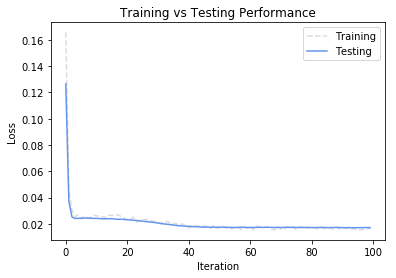

In [83]:
#
# Plot the training results
#
import matplotlib.pyplot as plt
plt.figure()
plt.title("Training vs Testing Performance")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt_train, = plt.plot(history['train_loss'], '--', color="gainsboro", label='Training')
plt_test, = plt.plot(history['test_loss'], color='cornflowerblue', label='Testing')
plt.legend(handles=[plt_train, plt_test])
plt.show()

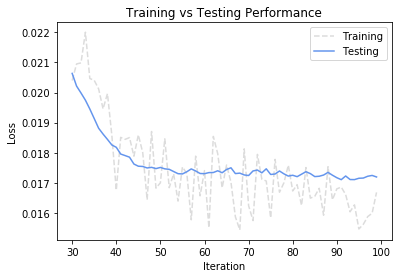

In [85]:
#
# Plot the last values of the training results
#
import matplotlib.pyplot as plt
plt.figure()
plt.title("Training vs Testing Performance")
plt.xlabel("Iteration")
plt.ylabel("Loss")
cut_into = 30
y_axis = list(range(cut_into, epochs))
plt_train, = plt.plot(y_axis, history['train_loss'][cut_into:], '--', color="gainsboro", label='Training')
plt_test, = plt.plot(y_axis, history['test_loss'][cut_into:], color='cornflowerblue', label='Testing')
plt.legend(handles=[plt_train, plt_test])
plt.show()